<div style="border-radius:20px; padding: 15px; background-color: #faedcd; font-size:105%; text-align:left; font-family: sans-serif">

Objective: Build and train a Convolutional Neural Network (CNN) to classify images from the Intel Image Classification dataset into one of six categories: buildings, forest, glacier, mountain, sea, or street.

<div style=" background-color: #d4a373; color:#ffffff; padding: 4px; border-radius: 8px; text-align: center; font-size: 110%; font-family: sans-serif">
    
## Step 1 | Imports and Setup


In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 94% 325M/346M [00:00<00:00, 663MB/s]
100% 346M/346M [00:00<00:00, 665MB/s]


In [3]:
import zipfile

with zipfile.ZipFile("intel-image-classification.zip", "r") as zip_ref:
    zip_ref.extractall("intel-image-classification")

In [4]:
import os

# List the directories
print(os.listdir("intel-image-classification"))

['seg_pred', 'seg_train', 'seg_test']


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
# import cv2
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_curve, auc
)
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D,
    Dense, Dropout, Flatten, BatchNormalization, Activation, Input
)
from keras.applications import ResNet50, EfficientNetB0
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2
from keras import layers, optimizers, callbacks
from keras.models import load_model

import warnings
import matplotlib.image as mpimg
warnings.filterwarnings('ignore')

<div style=" background-color: #d4a373; color:#ffffff; padding: 4px; border-radius: 8px; text-align: center; font-size: 110%; font-family: sans-serif">
    
## Step 2 | Dataset Exploration

**Step 2: Data Exploration and Preprocessing**

* Load and explore dataset structure
* Analyze class distribution
* Visualize sample images from each category
* Implement data preprocessing pipeline
* Create data generators with augmentation

In [6]:
# Dataset Structures:

In [7]:
def dataset_structure(data_path="intel-image-classification/"):
    """
    Explore the structure of Intel Image Classification dataset
    """
    # Check main directories
    subdirs = ['seg_train/seg_train', 'seg_test/seg_test']
    for subdir in subdirs:
        path = os.path.join(data_path, subdir)
        if os.path.exists(path):
            print(f"\n{subdir.upper()} Directory:")
            categories = os.listdir(path)
            print(f"Categories: {categories}")

            # Count images in each category
            for category in categories:
                cat_path = os.path.join(path, category)
                if os.path.isdir(cat_path):
                    count = len(os.listdir(cat_path))
                    print(f"  {category}: {count} images")

In [8]:
dataset_structure()


SEG_TRAIN/SEG_TRAIN Directory:
Categories: ['street', 'glacier', 'sea', 'forest', 'mountain', 'buildings']
  street: 2382 images
  glacier: 2404 images
  sea: 2274 images
  forest: 2271 images
  mountain: 2512 images
  buildings: 2191 images

SEG_TEST/SEG_TEST Directory:
Categories: ['street', 'glacier', 'sea', 'forest', 'mountain', 'buildings']
  street: 501 images
  glacier: 553 images
  sea: 510 images
  forest: 474 images
  mountain: 525 images
  buildings: 437 images


In [9]:
# visual some sample image from each class:

In [10]:
def visualize_samples(train_path, categories):
    plt.figure(figsize=(7, 4))
    for i, category in enumerate(categories[:6]):
        category_path = os.path.join(train_path, category)

        # Filter only image files
        valid_images = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not valid_images:
            continue  # Skip if no images in the folder

        img_name = valid_images[1]
        img_path = os.path.join(category_path, img_name)
        img = mpimg.imread(img_path)

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

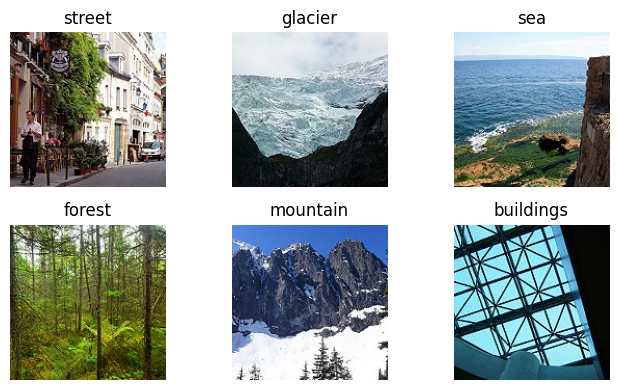

In [11]:
train_path = "intel-image-classification/seg_train/seg_train"
test_path = "intel-image-classification/seg_test/seg_test"
# validate_path = "dataset/seg_pred"
categories = os.listdir(train_path)

visualize_samples(train_path, categories)

In [12]:
# Classes Distribution in Dataset:

In [13]:
def class_distribution(train_path, test_path):
    """
    Analyze and visualize class distribution
    """
    train_counts = {}
    test_counts = {}

    # Count training images
    for category in os.listdir(train_path):
        cat_path = os.path.join(train_path, category)
        if os.path.isdir(cat_path):
            train_counts[category] = len(os.listdir(cat_path))

    # Count test images
    for category in os.listdir(test_path):
        cat_path = os.path.join(test_path, category)
        if os.path.isdir(cat_path):
            test_counts[category] = len(os.listdir(cat_path))

    return train_counts, test_counts

In [14]:
dist_class = class_distribution(train_path, test_path)

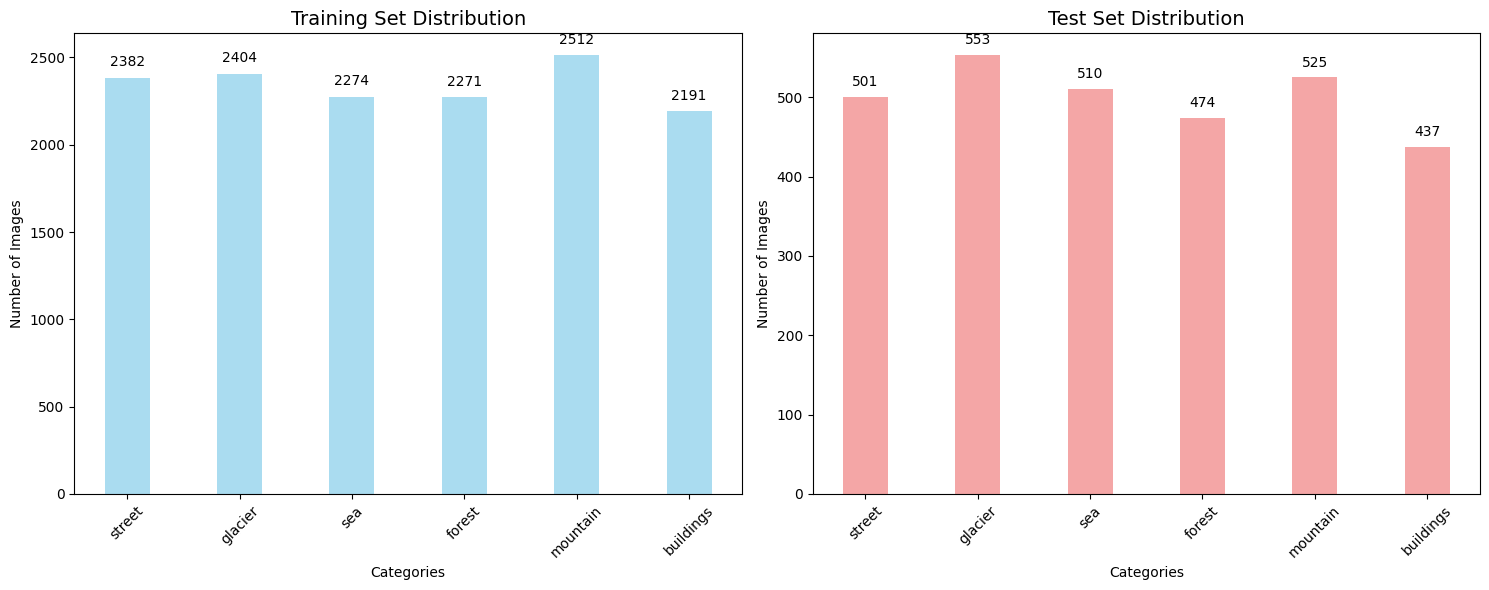

In [15]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training distribution
categories = list(dist_class[0].keys())
train_values = list(dist_class[0].values())
ax1.bar(categories, train_values, color='skyblue', alpha=0.7, width=0.4)
ax1.set_title('Training Set Distribution', fontsize=14)
ax1.set_xlabel('Categories')
ax1.set_ylabel('Number of Images')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(train_values):
    ax1.text(i, v + 50, str(v), ha='center', va='bottom')

# Test distribution
test_values = list(dist_class[1].values())
ax2.bar(categories, test_values, color='lightcoral', alpha=0.7, width=0.4)
ax2.set_title('Test Set Distribution', fontsize=14)
ax2.set_xlabel('Categories')
ax2.set_ylabel('Number of Images')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(test_values):
    ax2.text(i, v + 10, str(v), ha='center', va='bottom',)

plt.tight_layout()
plt.show()

In [16]:
# Lets analyze images propertis to better understand our dataset

In [17]:
def image_properties(path="intel-image-classification/"):
    """
    Analyze image properties like dimensions, channels, etc.
    """
    train_path = os.path.join(path, 'seg_train/seg_train')
    categories = os.listdir(train_path)

    dimensions = []
    channels = []
    file_sizes = []

    # Sample 100 random images for analysis
    sample_count = 0
    target_samples = 100

    for category in categories:
        cat_path = os.path.join(train_path, category)
        images = os.listdir(cat_path)

        valid_images = [f for f in os.listdir(cat_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not valid_images:
            continue  # Skip if no images in the folder

        for img_name in valid_images[:target_samples//len(categories)]:
            if sample_count >= target_samples:
                break

            img_path = os.path.join(cat_path, img_name)
            try:
                img = Image.open(img_path)
                img_array = np.array(img)

                dimensions.append(img_array.shape[:2])
                channels.append(img_array.shape[2] if len(img_array.shape) == 3 else 1)
                file_sizes.append(os.path.getsize(img_path))
                sample_count += 1

            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    # Analysis results
    unique_dims = list(set(dimensions))
    unique_channels = list(set(channels))

    print(f"Analyzed {len(dimensions)} images")
    print(f"Unique dimensions: {unique_dims}")
    print(f"Channels: {unique_channels}")
    print(f"Average file size: {np.mean(file_sizes)/1024:.2f} KB")
    print(f"File size range: {min(file_sizes)/1024:.2f} - {max(file_sizes)/1024:.2f} KB")

In [18]:
image_properties()

Analyzed 96 images
Unique dimensions: [(108, 150), (150, 150)]
Channels: [3]
Average file size: 15.11 KB
File size range: 5.67 - 23.21 KB


<div style="border-radius:20px; padding: 15px; background-color: #faedcd; font-size:105%; text-align:left; font-family: sans-serif">

**Explanation:**
* Exploring the dataset helps identify its size (e.g., ~14,000 training images, ~3,000 test images) and class distribution. Visualization confirms data quality and variety, ensuring the model will train on diverse examples. Your code shows a balanced dataset, which is ideal for classification.

**Description:**
Before building a model, it's crucial to understand the dataset. This step involves:

* Loading and Exploring Dataset Structure (dataset_structure function): Identifying the main directories (seg_train, seg_test) and the categories (classes) within them. The output confirms 6 categories: 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'. It also counts the number of images per category in both training and test sets, which is vital for understanding class balance.
* Visualizing Sample Images (visualize_samples function): Displaying a few sample images from each category helps in getting a qualitative feel for the data, its diversity, and potential challenges (e.g., variations in lighting, viewpoint).
* Analyzing Class Distribution (class_distribution function): Quantifying the number of images in each class for both training and test sets. The bar chart visualization (Cell 11) provides a clear view of this distribution, confirming if the dataset is balanced or if any class is under/over-represented. Your dataset appears reasonably balanced.
* Analyzing Image Properties (image_properties function): Checking characteristics of a sample of images, such as dimensions, number of channels (RGB vs. grayscale), and average file sizes. Your analysis showed varying dimensions (e.g., 150x150, 113x150) and consistent 3-channel (RGB) images. This informs preprocessing needs like resizing.

Data exploration provides insights into the dataset's characteristics, helping to make informed decisions during preprocessing and model design. It ensures data quality and helps anticipate potential issues like class imbalance or inconsistent image formats

<div style=" background-color: #d4a373; color:#ffffff; padding: 4px; border-radius: 8px; text-align: center; font-size: 110%; font-family: sans-serif">
    
## Step 3 | Data Preprocessing

In [19]:
img_size = (150, 150)  # Standardize image size for model input
batch_size = 32        # Batch size for efficient training
num_classes = 6        # Number of categories in the dataset
input_shape = (150, 150, 3)

def data_generators(path='intel-image-classification/'):
    """
    Create data generators with augmentation for training and validation
    """
    train_path = os.path.join(path, 'seg_train/seg_train')
    test_path = os.path.join(path, 'seg_test/seg_test')

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    )
    # Only rescaling for test data
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    print(f"Training samples: {train_generator.samples}")
    print(f"Test samples: {test_generator.samples}")
    print(f"Number of classes: {train_generator.num_classes}")
    print(f"Class indices: {train_generator.class_indices}")

    return train_generator, test_generator

In [20]:
def augmented_images(train_generator):
    """
    Visualize augmented images to understand data augmentation
    """
    # Get a batch of augmented images
    batch_x, batch_y = next(train_generator)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')

    for i in range(8):
        row = i // 4
        col = i % 4

        # Display image
        axes[row, col].imshow(batch_x[i])

        # Get class name
        class_idx = np.argmax(batch_y[i])
        class_names = list(train_generator.class_indices.keys())
        class_name = class_names[class_idx]

        axes[row, col].set_title(f'Class: {class_name}', fontweight='bold')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Training samples: 14034
Test samples: 3000
Number of classes: 6
Class indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


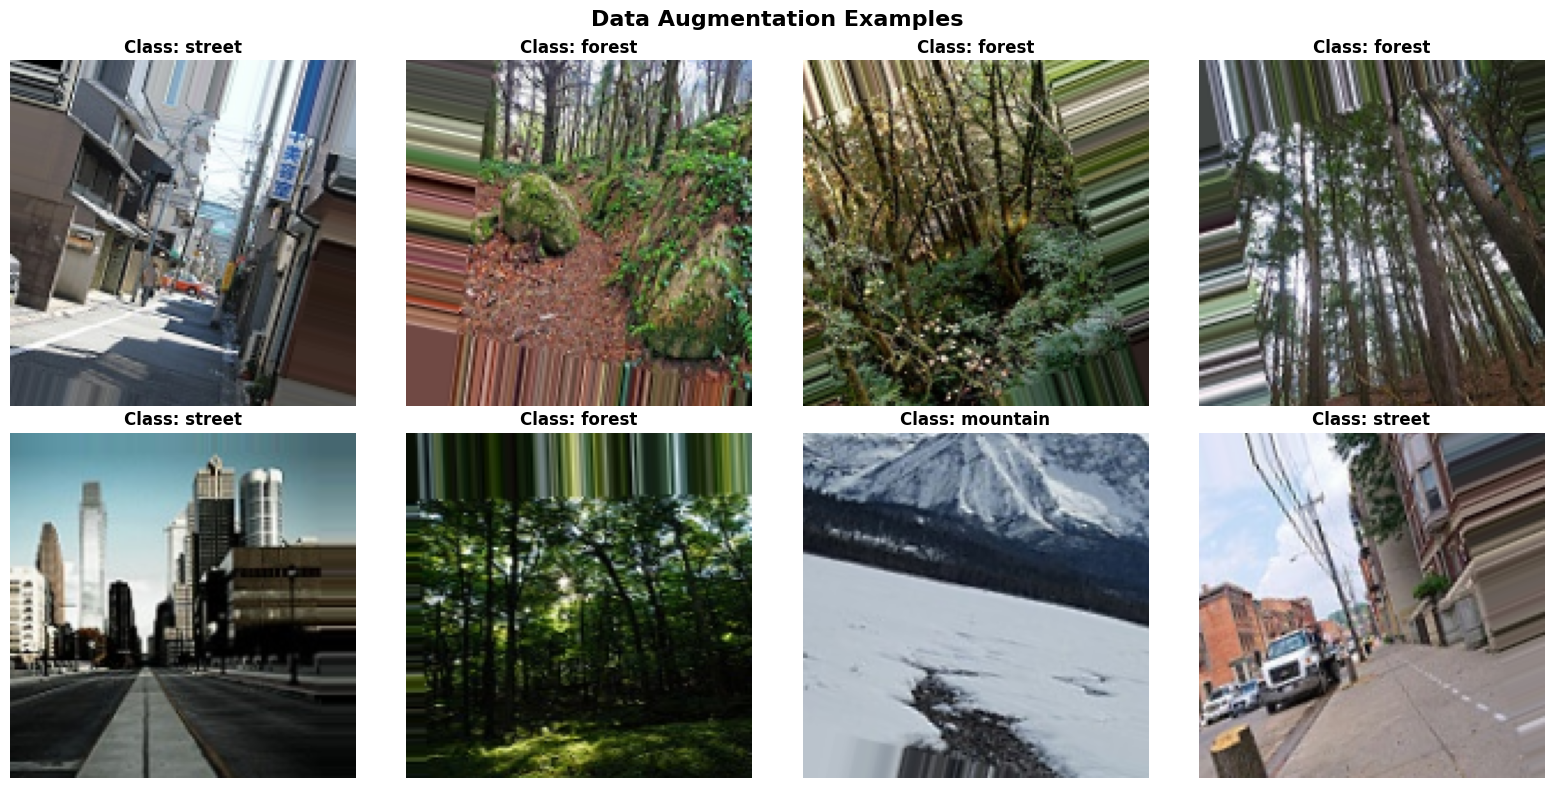

In [22]:
train_gen, test_gen = data_generators()
augmented_images(train_gen)

In [23]:
class_labels = list(train_gen.class_indices.keys())

<div style="border-radius:20px; padding: 15px; background-color: #faedcd; font-size:105%; text-align:left; font-family: sans-serif">

**Explanation:**
* Preprocessing ensures images are in a consistent format (size and scale) for the CNN. Normalization stabilizes training, while augmentation simulates real-world variations, reducing overfitting.

**Description:**
This step prepares the raw image data for input into the CNN model. It involves:

**1-** Importing ImageDataGenerator: A Keras utility for real-time data augmentation and preprocessing.

**2-** Defining Data Generators:
* Rescaling: Image pixel values (typically 0-255) are rescaled to a smaller range (0-1 by dividing by 255). This normalization helps in faster and more stable training. Suggestion: If using a pre-trained model, use its specific preprocess_input function.
* Data Augmentation (for training set): Techniques like rotation_range, width_shift_range, height_shift_range, shear_range, zoom_range, and horizontal_flip are applied. This artificially increases the size and diversity of the training dataset by creating modified versions of existing images, helping the model generalize better and reduce overfitting.
* No Augmentation for Test/Validation Set: The test_datagen only performs rescaling, as the model's performance should be evaluated on unaltered data.
* Flowing from Directory: flow_from_directory is used to load images from their respective class folders. It automatically infers class labels from folder names.
* * target_size: Images are resized to a uniform size (e.g., 150x150 pixels) as CNNs require fixed-size inputs.
* * batch_size: Images are processed in batches (e.g., 32 images per batch) for memory efficiency and stable gradient updates.
* * class_mode='categorical': Labels are one-hot encoded.

**3-** Visualizing Augmented Images: This function (called in cell 18 after creating generators) would display examples of augmented images, helping to verify that the augmentation settings are reasonable and producing diverse yet realistic training samples.

Preprocessing standardizes the input data and data augmentation makes the model more robust by exposing it to a wider variety of image variations. ImageDataGenerator automates this process efficiently.

**Key Steps:**
- Loading: Use TensorFlow's utility to load images efficiently.
- Resizing: Standardize images to 150x150 pixels.
- Normalization: Scale pixel values to [0, 1] for better convergence.
- Augmentation: Apply random transformations to improve generalization.

<div style=" background-color: #d4a373; color:#ffffff; padding: 4px; border-radius: 8px; text-align: center; font-size: 110%; font-family: sans-serif">
    
## Step 4 | Model Definition

**Create Basic Cnn Model**

In [24]:
def basic_cnn(input_shape, num_classes):
    """
    Create a basic CNN architecture for image classification
    """
    model = Sequential([
        # First Convolutional Block
        Input(shape=(input_shape)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Third Convolutional Block
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Flatten and Dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer= Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [25]:
basic_cnn_model = basic_cnn(input_shape, num_classes)

In [26]:
basic_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,814,534 (26.00 MB)

 Trainable params: 6,814,534 (26.00 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Using Early stoping:

from keras.callbacks import EarlyStopping

basic_earlystop = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=4,             # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True # Crucially, restore weights from the epoch with the best monitored quantity
    )

In [28]:
print('Start Training The Model !')
basic_hist = basic_cnn_model.fit(train_gen, validation_data=test_gen, callbacks=basic_earlystop, epochs=15)
print('Training Completed !')

Start Training The Model !
Epoch 1/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 104s 220ms/step - accuracy: 0.4238 - loss: 1.3932 - val_accuracy: 0.6553 - val_loss: 0.9495
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 92s 209ms/step - accuracy: 0.6059 - loss: 1.0196 - val_accuracy: 0.7140 - val_loss: 0.7823
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 93s 211ms/step - accuracy: 0.6586 - loss: 0.9096 - val_accuracy: 0.7227 - val_loss: 0.7625
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 140s 206ms/step - accuracy: 0.6905 - loss: 0.8266 - val_accuracy: 0.7477 - val_loss: 0.6797
Epoch 5/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 91s 207ms/step - accuracy: 0.7183 - loss: 0.7627 - val_accuracy: 0.7800 - val_loss: 0.6069
Epoch 6/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 93s 213ms/step - accuracy: 0.7341 - loss: 0.7345 - val_accuracy: 0.7967 - val_loss: 0.5585
Epoch 7/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 93s 212ms/step - accuracy: 0.7518 - loss: 0.6829 - val_accuracy: 0.8113 - val_loss: 0.5286
Epoch 8/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 90s 205ms/step

In [29]:
basic_hist.history

{'accuracy': [0.5117571353912354,
  0.622773289680481,
  0.6675217151641846,
  0.6969502568244934,
  0.7160467505455017,
  0.735998272895813,
  0.7529571056365967,
  0.7575886845588684,
  0.7714123129844666,
  0.777896523475647,
  0.7815305590629578,
  0.7904375195503235,
  0.7920764088630676,
  0.798560619354248,
  0.8044036030769348],
 'loss': [1.218715786933899,
  0.9772669672966003,
  0.8864502906799316,
  0.8097743988037109,
  0.7646076083183289,
  0.7249453067779541,
  0.6782678365707397,
  0.6729655265808105,
  0.6295419931411743,
  0.6127725839614868,
  0.6005672812461853,
  0.5813546180725098,
  0.5681653618812561,
  0.5624716281890869,
  0.5383634567260742],
 'val_accuracy': [0.6553333401679993,
  0.7139999866485596,
  0.7226666808128357,
  0.7476666569709778,
  0.7799999713897705,
  0.79666668176651,
  0.8113333582878113,
  0.7743333578109741,
  0.8216666579246521,
  0.7806666493415833,
  0.8106666803359985,
  0.8273333311080933,
  0.8426666855812073,
  0.8226666450500488,
 

**Create Deep Cnn Model**

In [30]:
def deep_cnn(input_shape, num_classes):
    model = Sequential([

        # First Convolutional Block
        Input(shape= input_shape),
        Conv2D(32,(3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(32,(3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),

        # Second Convolutional Block
        Conv2D(filters=64, kernel_size=(3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(filters=64, kernel_size=(3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2,2)),

        # Third Convolutional Block
        Conv2D(128, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(128, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2,2)),

        # Fourth Convolutional Block
        Conv2D(256, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(256, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2,2)),

        # Global Average Pooling instead of Flatten
        GlobalAveragePooling2D(),

        # Dense Layers
        Dense(512), # kernel_regularizer=l2(0.001)
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),

        # Output Dense Layer
        Dense(num_classes, activation='softmax'),
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [31]:
deep_model = deep_cnn(input_shape, num_classes)

In [32]:
deep_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 18, 18, 256)    │       295,16

 Total params: 1,312,806 (5.01 MB)

 Trainable params: 1,309,862 (5.00 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [33]:
# Define some callbacks:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
deep_earlystop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [34]:
print('Start training deep model\n')
deep_hist = deep_model.fit(train_gen, validation_data=test_gen, epochs=20, batch_size=32, callbacks=[deep_earlystop, reduce_lr])
print('Deep model trained succsessfully !')

Start training deep model

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 129s 255ms/step - accuracy: 0.5037 - loss: 1.3367 - val_accuracy: 0.6517 - val_loss: 0.9178 - learning_rate: 0.0010
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 101s 230ms/step - accuracy: 0.6957 - loss: 0.8204 - val_accuracy: 0.4570 - val_loss: 2.1427 - learning_rate: 0.0010
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 102s 231ms/step - accuracy: 0.7461 - loss: 0.6987 - val_accuracy: 0.6680 - val_loss: 0.9580 - learning_rate: 0.0010
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 102s 232ms/step - accuracy: 0.7735 - loss: 0.6366 - val_accuracy: 0.7060 - val_loss: 0.9728 - learning_rate: 0.0010
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 141s 229ms/step - accuracy: 0.7869 - loss: 0.5757 - val_accuracy: 0.5923 - val_loss: 1.5302 - learning_rate: 0.0010
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8043 - loss: 0.5353
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
439/439 ━━━━━━━━━━━━━━━━━━━━

In [35]:
# deep_hist.history['accuracy'][-1:]
deep_hist.history['val_accuracy'][-1:]

[0.8703333139419556]

**Transfer Learning And Fine Tuning ResNet50 Model**

In [36]:
def create_resnet_model(input_shape, num_classes, trainable_layers=10):
    """Create ResNet50 model with transfer learning"""

    # Load pre-trained ResNet50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model layers except the last few
    base_model.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    # Create functional model
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model, base_model

In [37]:
initial_resnet_model , base_model = create_resnet_model(input_shape, num_classes)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [38]:
def compile_model(model, learning_rate=0.001):
    """Compile model with optimizer and metrics"""
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [39]:
def create_callbacks(model_name, patience=3):
    """Create callbacks for training"""
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
    ]
    return callbacks_list

In [40]:
def train_model(model, train_gen, val_gen, model_name, epochs=20):


    # Get callbacks
    callback_list = create_callbacks(model_name)

    # Train model
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callback_list,
        verbose=1
    )

    return history

In [41]:
def fine_tune_model(model, base_model, train_gen, val_gen, model_name, epochs=30):


    # Unfreeze more layers for fine-tuning
    base_model.trainable = True

    # Use a lower learning rate for fine-tuning
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001/10),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Create callbacks for fine-tuning
    callback_list = create_callbacks(f'{model_name}_finetuned', patience=6)

    # Fine-tune model
    history_fine = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callback_list,
        verbose=1
    )

    return history_fine

In [42]:
def training_pipeline(train_gen, val_gen):

    # Create and compile ResNet model
    resnet_model, resnet_base = create_resnet_model(input_shape, num_classes)
    resnet_model = compile_model(resnet_model, learning_rate=0.001)

    print(f"ResNet50 Model Summary:")
    resnet_model.summary()

    # Initial training
    resnet_history = train_model(resnet_model, train_gen, val_gen, "resnet50", epochs=10)

    # Fine-tuning
    resnet_history_fine = fine_tune_model(
        resnet_model, resnet_base, train_gen, val_gen, "resnet50", epochs=15
    )

    return resnet_model, resnet_history, resnet_history_fine

In [43]:
resnet_model, resnet_hist, resnet_hist_fine = training_pipeline(train_gen, test_gen)

ResNet50 Model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,771,718 (94.50 MB)

 Trainable params: 5,648,646 (21.55 MB)

 Non-trainable params: 19,123,072 (72.95 MB)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 141s 278ms/step - accuracy: 0.3564 - loss: 1.6932 - val_accuracy: 0.5537 - val_loss: 1.1000 - learning_rate: 0.0010
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 102s 231ms/step - accuracy: 0.5162 - loss: 1.1910 - val_accuracy: 0.5003 - val_loss: 1.2715 - learning_rate: 0.0010
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 104s 238ms/step - accuracy: 0.5617 - loss: 1.1030 - val_accuracy: 0.5433 - val_loss: 1.1411 - learning_rate: 0.0010
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 105s 240ms/step - accuracy: 0.5798 - loss: 1.0634 - val_accuracy: 0.6143 - val_loss: 0.9180 - learning_rate: 0.0010
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 106s 241ms/step - accuracy: 0.5941 - loss: 1.0302 - val_accuracy: 0.5370 - val_loss: 1.3499 - learning_rate: 0.0010
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 106s 242ms/step - accuracy: 0.6031 - loss: 1.0271 - val_accuracy: 0.6470 - val_loss: 0.9230 - learning_rate: 0.0010
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy

In [46]:
resnet_hist_fine.history

{'accuracy': [0.6525580883026123,
  0.8175145983695984,
  0.8544249534606934,
  0.874305248260498,
  0.8934017419815063,
  0.9023799300193787,
  0.9080091118812561,
  0.913424551486969,
  0.9229015111923218,
  0.9286019802093506,
  0.9311671853065491,
  0.9390765428543091,
  0.94007408618927,
  0.9397890567779541,
  0.9436368942260742],
 'loss': [0.9850865006446838,
  0.5929393172264099,
  0.4621623456478119,
  0.39061233401298523,
  0.3389970660209656,
  0.306794136762619,
  0.28317251801490784,
  0.2629953622817993,
  0.23723261058330536,
  0.21489842236042023,
  0.21050739288330078,
  0.18945012986660004,
  0.17906980216503143,
  0.18053863942623138,
  0.16833192110061646],
 'val_accuracy': [0.35066667199134827,
  0.8226666450500488,
  0.9056666493415833,
  0.9106666445732117,
  0.9133333563804626,
  0.9233333468437195,
  0.9233333468437195,
  0.9269999861717224,
  0.9259999990463257,
  0.9293333292007446,
  0.9269999861717224,
  0.9279999732971191,
  0.9296666383743286,
  0.9343333

**Explanation:**
* The CNN extracts features through convolutions, reduces spatial dimensions with pooling, and prevents overfitting with dropout and normalization. A deeper architecture captures complex patterns, making it suitable for image classification.
* Training adjusts the model’s weights to minimize classification errors. Validation monitoring detects overfitting, and plotting history provides insights into learning dynamics. Adding EarlyStopping would halt training when performance plateaus, saving time and resources.

**Architecture:**
- Conv2D Layers: Extract spatial features from images.
- MaxPooling: Reduce dimensionality while retaining key features.
- Dropout: Prevent overfitting by randomly dropping units.
- Dense Layers: Perform final classification.
- Optimizer: Adam, a robust choice for gradient descent.
- Loss: Categorical crossentropy for multi-class classification.
- Callbacks: Early stopping to prevent overfitting.

## Step 5 | Model Evaluation

In [49]:
models = {'Basic Model': basic_cnn_model, 'Deep Model': deep_model, 'Resnet Model': resnet_model}

In [50]:
def model_accuracy(model, test_gen, model_name):
    """Evaluate model on test set"""

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)

    print(f"\n{model_name} Test Results:")
    print(f"Test Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")
    print(f"Test Loss: {test_loss:.4f}")

    return test_accuracy , test_loss

In [51]:
model_result = [ model_accuracy(model, test_gen, name) for name, model in models.items()]

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8552 - loss: 0.4155

Basic Model Test Results:
Test Accuracy: 0.849 (84.9%)
Test Loss: 0.4264
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8248 - loss: 0.4428

Deep Model Test Results:
Test Accuracy: 0.870 (87.0%)
Test Loss: 0.3533
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9307 - loss: 0.2118

Resnet Model Test Results:
Test Accuracy: 0.934 (93.4%)
Test Loss: 0.2003


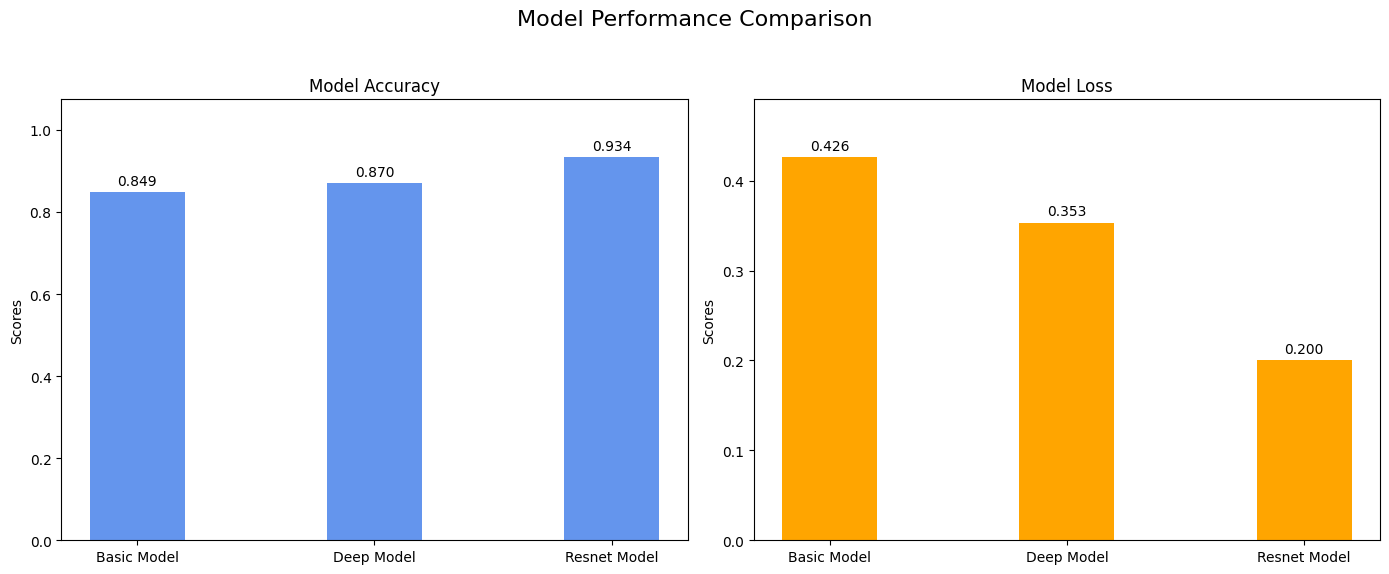

In [52]:
model_names = ["Basic Model", "Deep Model", "Resnet Model"]
accuracies = [item[0] for item in model_result]
losses = [item[1] for item in model_result]

x = np.arange(len(model_result))

width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Model Performance Comparison', fontsize=16)

# --- 3. Create the Accuracy Plot (Left) ---
ax1.bar(model_names, accuracies, color='cornflowerblue', width=0.4)
ax1.set_ylabel('Scores')
ax1.set_title('Model Accuracy')
ax1.set_ylim(0, max(accuracies) * 1.15) # Set y-limit for better spacing
# Add bar labels
ax1.bar_label(ax1.containers[0], padding=3, fmt='%.3f')


# --- 4. Create the Loss Plot (Right) ---
ax2.bar(model_names, losses, color='orange', width=0.4)
ax2.set_ylabel('Scores')
ax2.set_title('Model Loss')
ax2.set_ylim(0, max(losses) * 1.15) # Set y-limit for better spacing
# Add bar labels
ax2.bar_label(ax2.containers[0], padding=3, fmt='%.3f')


# --- 5. Final Touches ---
# Ensure the layout is tight and clean
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle

# Display the plot
plt.show()

In [53]:
def evaluate_model(model, test_generator, model_name):
    """
    Comprehensive model evaluation on test set
    """
    # Reset test generator
    test_generator.reset()

    # Get predictions
    print("Generating predictions...")
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Calculate basic metrics
    test_accuracy = accuracy_score(true_classes, predicted_classes)
    test_loss = model.evaluate(test_generator, verbose=0)[0]

    print(f"\n{model_name} Test Results:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Generate detailed classification report
    class_report = classification_report(
        true_classes, predicted_classes,
        target_names=class_labels,
        output_dict=True
    )

    # Calculate per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        true_classes, predicted_classes, average=None
    )

    # Create evaluation summary
    evaluation_summary = {
        'model_name': model_name,
        'test_accuracy': float(test_accuracy),
        'test_loss': float(test_loss),
        'classification_report': class_report,
        'per_class_metrics': {
            class_labels[i]: {
                'precision': float(precision[i]),
                'recall': float(recall[i]),
                'f1_score': float(f1[i]),
                'support': int(support[i])
            } for i in range(len(class_labels))
        }
    }

    return evaluation_summary

In [54]:
eval_summary = [evaluate_model(model, test_gen, model_name) for model_name, model in models.items()]

Generating predictions...
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step

Basic Model Test Results:
Test Accuracy: 0.8487
Test Loss: 0.4264
Generating predictions...
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step

Deep Model Test Results:
Test Accuracy: 0.8703
Test Loss: 0.3533
Generating predictions...
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step

Resnet Model Test Results:
Test Accuracy: 0.9343
Test Loss: 0.2003


In [55]:
def per_class_metrics(evaluation_summary, model_name):
    """
    Visualize per-class precision, recall, and F1-score
    """
    per_class_metrics = eval_summary[0]['per_class_metrics']
    classes = list(per_class_metrics.keys())

    precision_scores = [per_class_metrics[cls]['precision'] for cls in classes]
    recall_scores = [per_class_metrics[cls]['recall'] for cls in classes]
    f1_scores = [per_class_metrics[cls]['f1_score'] for cls in classes]

    x = np.arange(len(classes))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 8))

    bars1 = ax.bar(x - width, precision_scores, width, label='Precision', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x, recall_scores, width, label='Recall', alpha=0.8, color='lightcoral')
    bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8, color='lightgreen')

    ax.set_xlabel('Classes')
    ax.set_ylabel('Score')
    ax.set_title(f'Per-Class Performance Metrics - {model_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)

    plt.tight_layout()
    plt.show()

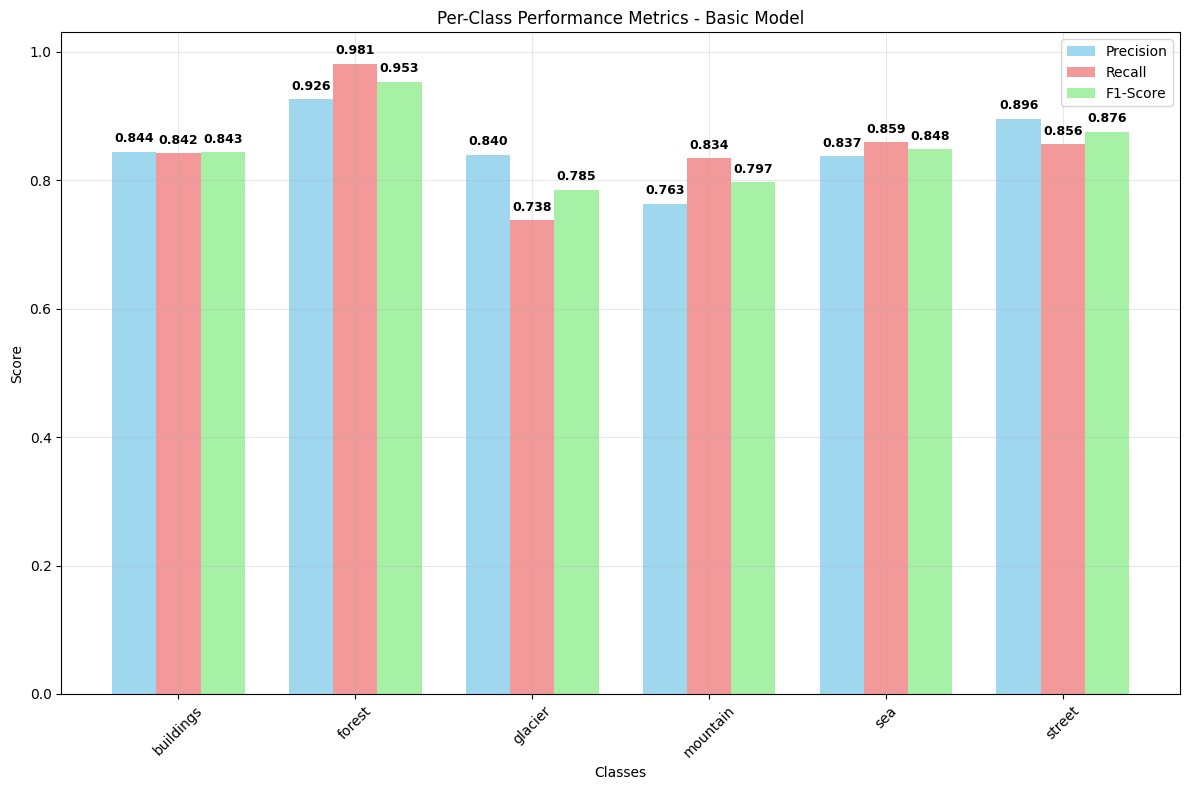

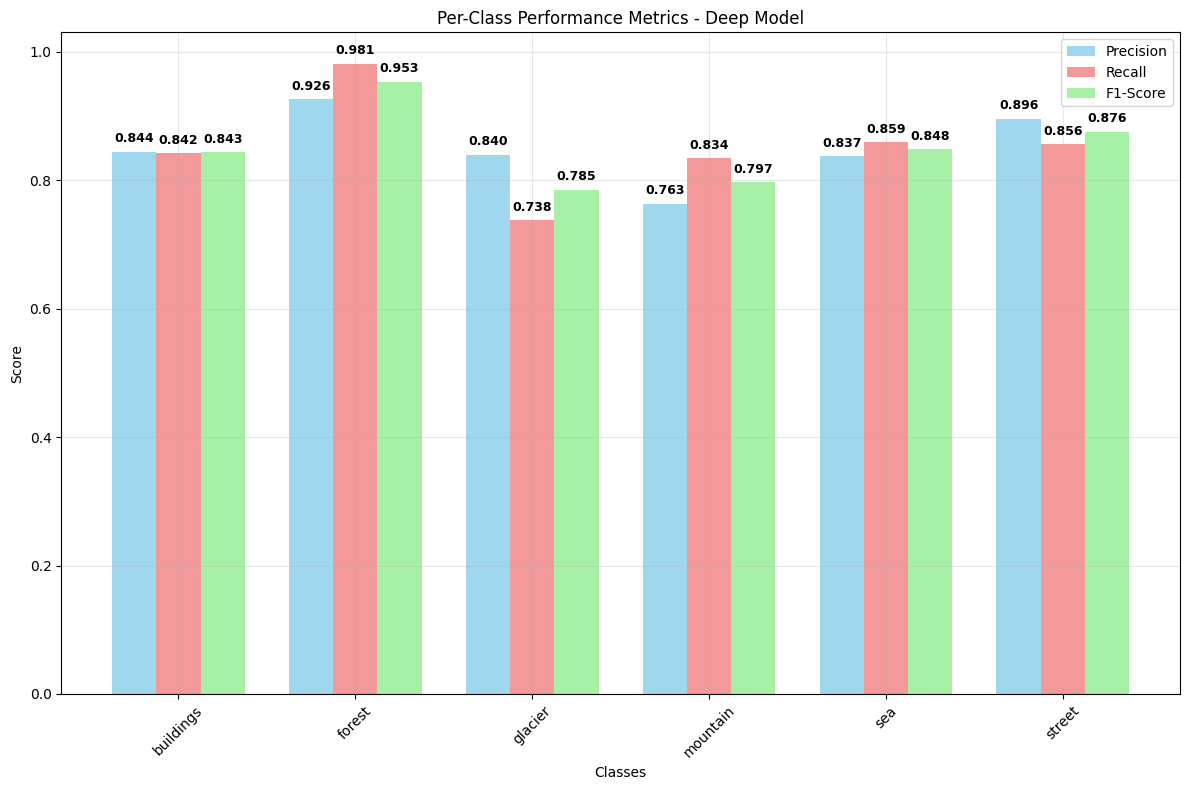

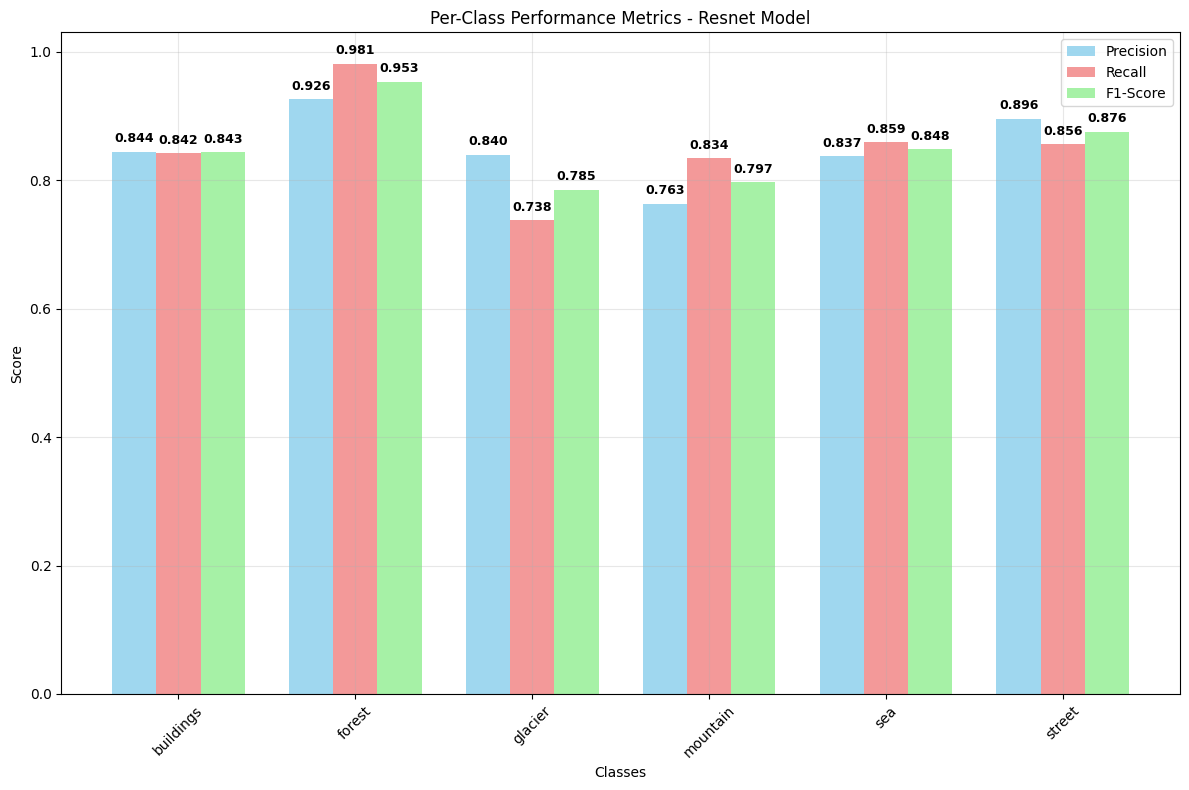

In [56]:
for i, (name, _) in enumerate( models.items() ):
    per_class_metrics(eval_summary[i], name )

In [57]:
def visual_accuracy(history, model_name):
    """
    Plots the training and validation accuracy for a given model's history.

    Args:
        history (dict): A dictionary containing 'accuracy' and 'val_accuracy' lists.
        model_name (str): The name of the model for the plot title.
    """
    # The number of epochs is determined by the length of the accuracy list
    epochs = range(1, len(history['accuracy']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'Performance Metrics for {model_name}', fontsize=14)

    # --- Plot 1: Accuracy ---
    ax1.plot(epochs, history['accuracy'], 'b-', label='Training Accuracy')
    ax1.plot(epochs, history['val_accuracy'], 'r--', label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylim(0.5, 1.0) # Adjust Y-axis for accuracy

    # --- Plot 2: Loss ---
    ax2.plot(epochs, history['loss'], 'g-', label='Training Loss')
    ax2.plot(epochs, history['val_loss'], 'y--', label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylim(bottom=0) # Loss starts from 0

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
    plt.show()

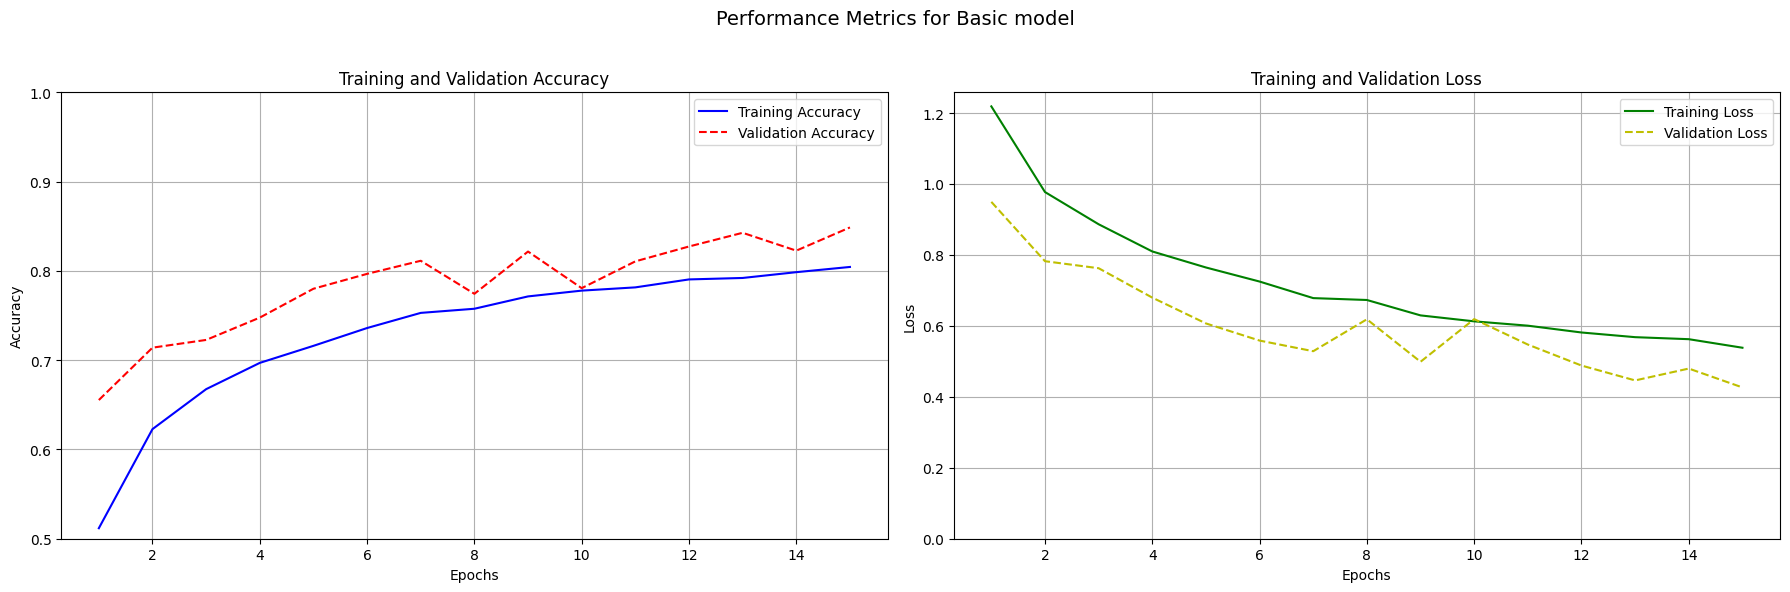

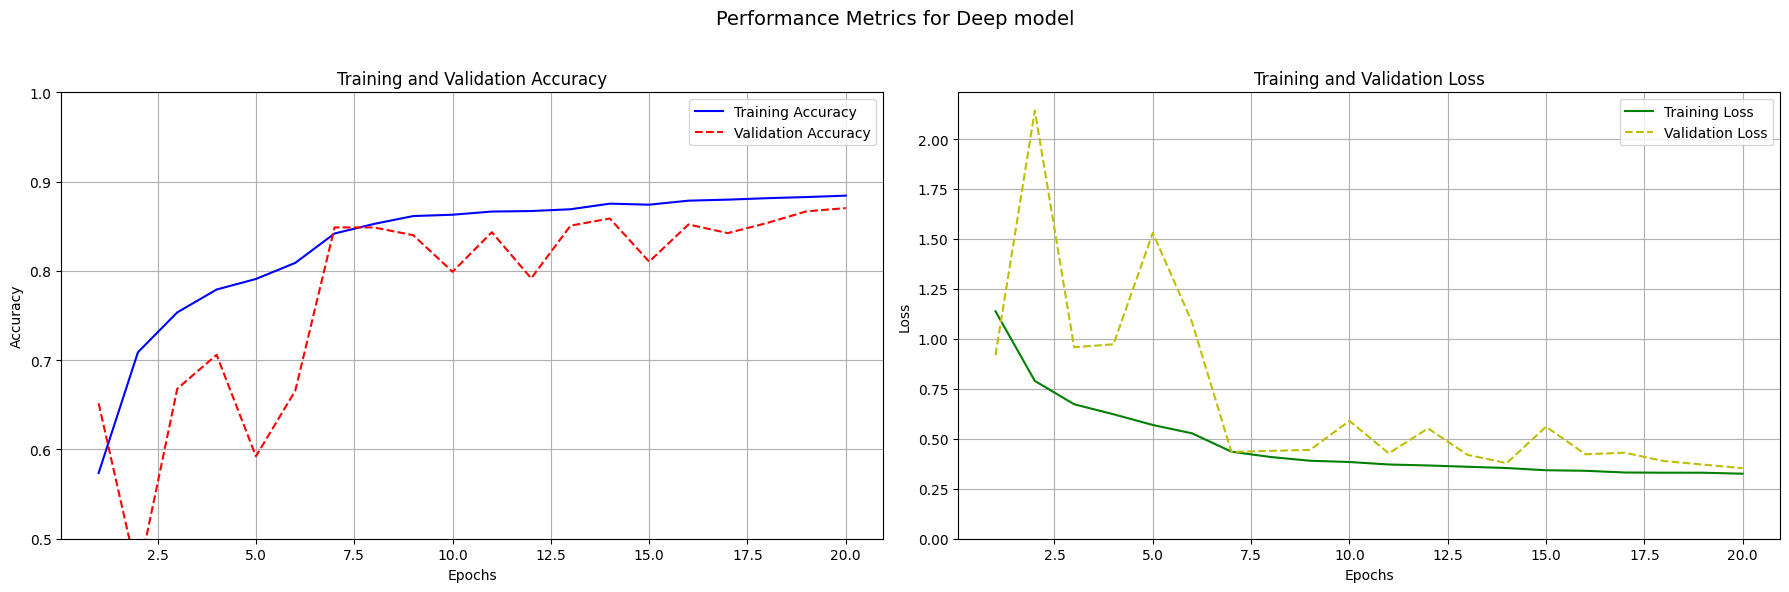

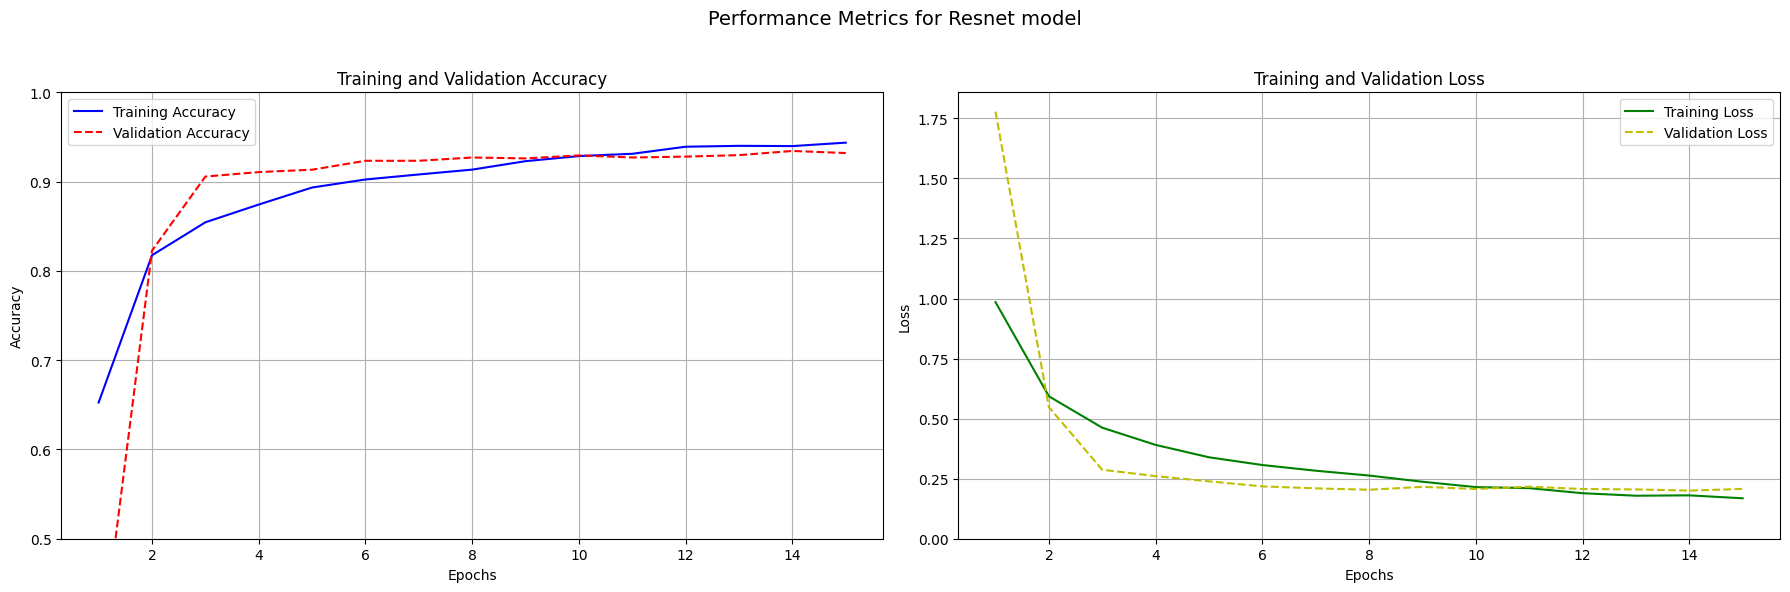

In [58]:
history = {'Basic model':basic_hist.history, 'Deep model': deep_hist.history, 'Resnet model': resnet_hist_fine.history}

for name, hist in history.items():
    visual_accuracy(hist, name)

In [59]:
def get_confusion_matrix(model, test_gen, model_name):
    """Get predictions and generate classification report"""
    # Get predictions
    predictions = model.predict(test_gen, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = test_gen.classes

    plt.figure(figsize=(9, 5))

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


<Figure size 900x500 with 0 Axes>

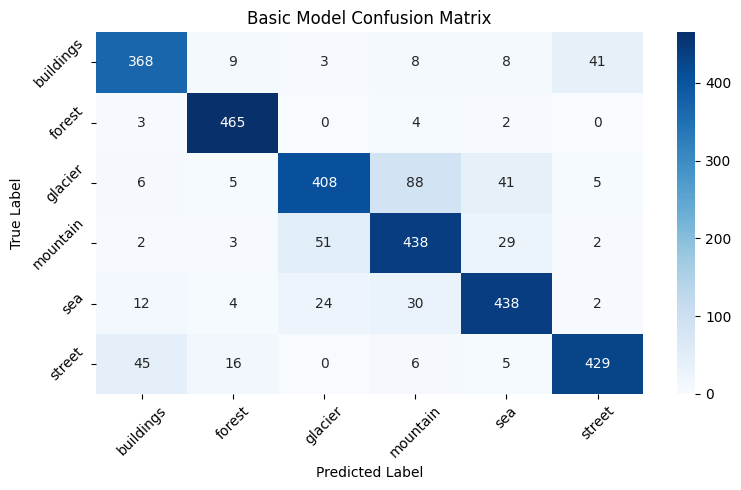

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step


<Figure size 900x500 with 0 Axes>

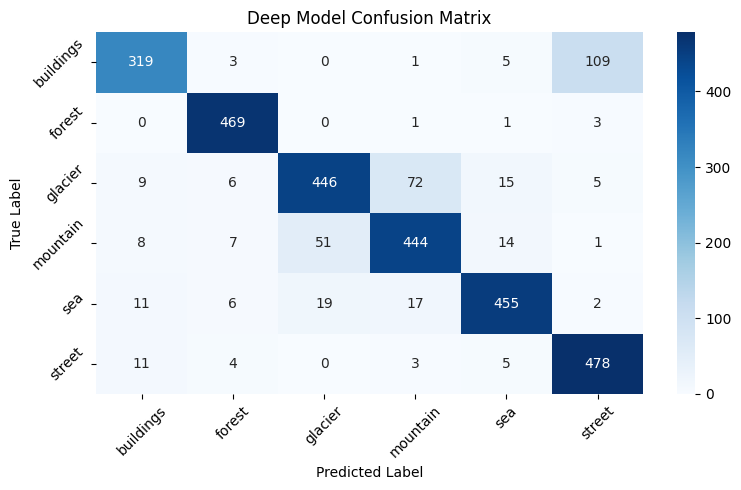

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step


<Figure size 900x500 with 0 Axes>

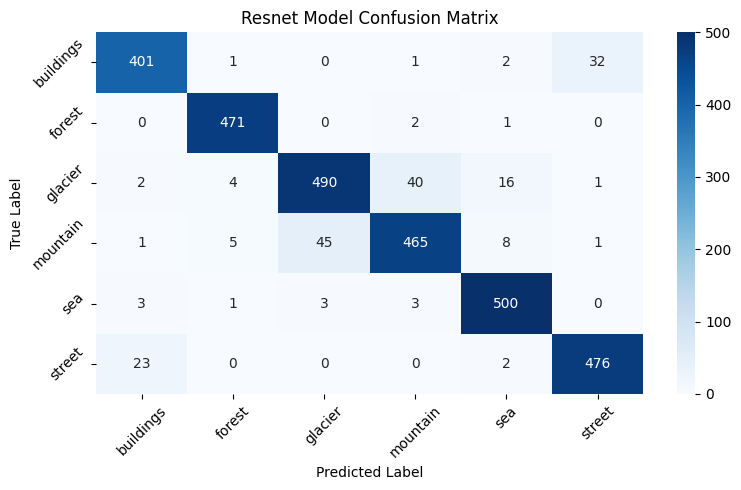

In [60]:
for name, model in models.items():
    get_confusion_matrix(model, test_gen, name)

**Explanation:**
* Evaluation quantifies the model’s generalization to unseen data. A confusion matrix reveals class-specific errors (e.g., confusing mountains with glaciers), while precision/recall highlight performance on imbalanced classes (though your dataset is balanced).

**Metrics:**
- Accuracy: Overall correctness of predictions.
- Classification Report: Precision, recall, and F1-score per class.
- Confusion Matrix: Visualizes prediction errors.

<div style=" background-color: #d4a373; color:#ffffff; padding: 4px; border-radius: 8px; text-align: center; font-size: 110%; font-family: sans-serif">
    
## Step 6 | Prediction and Visualization

In [ ]:
from keras.preprocessing import image

def preprocess_image(path):

    img_path = f"intel-image-classification/seg_pred/seg_pred/{path}.jpg"

    # Load the image from the file path, resizing it to the model's expected input size.
    img = image.load_img(img_path, target_size=(150, 150))

    # Convert the image to a NumPy array.
    # The shape will be (150, 150, 3).
    img_array = image.img_to_array(img)

    # Rescale the pixel values from [0, 255] to [0, 1], just like in the test_generator.
    img_array = img_array / 255.0

    # The model expects input of shape (batch_size, height, width, channels).
    # We expand the shape from (150, 150, 3) to (1, 150, 150, 3).
    img_batch = np.expand_dims(img_array, axis=0)

    return img_batch

In [62]:
from keras.utils import load_img
from keras.utils import img_to_array

def predict_new_data(model_name, model, path):

    # Get the model's prediction as a vector of probabilities
    prediction_vector = model.predict(preprocess_image(path))

    # Find the index of the class with the highest probability
    predicted_class_index = np.argmax(prediction_vector)

    # Get the name of the predicted class
    predicted_class_name = class_labels[predicted_class_index]

    # Get the confidence score of the prediction
    confidence = np.max(prediction_vector) * 100

    print(f"{model_name} Prediction: '{predicted_class_name}' with {confidence:.1f}% confidence.\n")


In [63]:
def show_image(path):
    img_path = f"intel-image-classification/seg_pred/seg_pred/{path}.jpg"

    plt.figure(figsize=(2, 4))
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [64]:
def make_prediction(path):
    for name, model in models.items():
        predict_new_data(name, model, path)

    show_image(path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
Basic Model Prediction: 'buildings' with 80.5% confidence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Deep Model Prediction: 'buildings' with 51.7% confidence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Resnet Model Prediction: 'buildings' with 96.1% confidence.



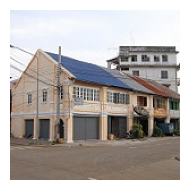

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Basic Model Prediction: 'sea' with 95.7% confidence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Deep Model Prediction: 'sea' with 100.0% confidence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Resnet Model Prediction: 'sea' with 100.0% confidence.



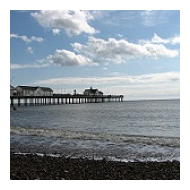

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Basic Model Prediction: 'buildings' with 48.6% confidence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Deep Model Prediction: 'buildings' with 98.3% confidence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Resnet Model Prediction: 'buildings' with 95.3% confidence.



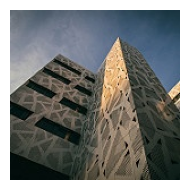

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Basic Model Prediction: 'street' with 90.5% confidence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Deep Model Prediction: 'street' with 99.7% confidence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Resnet Model Prediction: 'street' with 99.1% confidence.



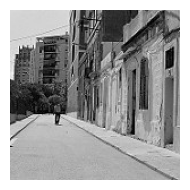

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Basic Model Prediction: 'glacier' with 98.6% confidence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Deep Model Prediction: 'glacier' with 99.5% confidence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Resnet Model Prediction: 'glacier' with 99.7% confidence.



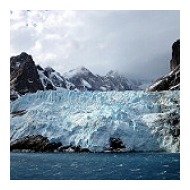

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Basic Model Prediction: 'street' with 96.9% confidence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Deep Model Prediction: 'street' with 98.9% confidence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Resnet Model Prediction: 'street' with 93.3% confidence.



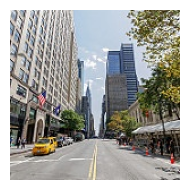

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Basic Model Prediction: 'mountain' with 57.3% confidence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Deep Model Prediction: 'forest' with 81.4% confidence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Resnet Model Prediction: 'mountain' with 97.2% confidence.



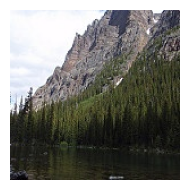

In [65]:
image_paths = [1206, 1241, 1276, 182, 310, 379, 629]
for img in image_paths:
    make_prediction(img)